In [1]:
import os
import librosa
import librosa.display

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import noisereduce as nr
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from PIL import Image
import IPython.display as ipd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Descomprimir cats_dogs.zip
zip_path = "cats_dogs.zip"
extract_path = os.getcwd()
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print(f"Archivos extraídos")

Archivos extraídos


### Example Audios

In [27]:
cat_file = 'train/cat/cat_119.wav'
ipd.Audio(cat_file)

In [31]:
dog_file = 'train/dog/dog_barking_101.wav'
ipd.Audio(dog_file)

In [32]:
y_cat, sr_cat = librosa.load(cat_file)
y_dog, sr_dog = librosa.load(dog_file)

# Información básica de los audios
print('--- Cat Audio ---')
print(f"Audio Length: {len(y_cat) / sr_cat} seconds")
print(f"Sample Rate: {sr_cat}")
print(f"Audio Shape: {y_cat.shape}")
print(f"Mean: {np.mean(y_cat)}")
print(f"Standard Deviation: {np.std(y_cat)}")
print(f"Min: {np.min(y_cat)}")
print(f"Max: {np.max(y_cat)}")

print('\n--- Dog Audio ---')
print(f"Audio Length: {len(y_dog) / sr_dog} seconds")
print(f"Sample Rate: {sr_dog}")
print(f"Audio Shape: {y_dog.shape}")
print(f"Mean: {np.mean(y_dog)}")
print(f"Standard Deviation: {np.std(y_dog)}")
print(f"Min: {np.min(y_dog)}")
print(f"Max: {np.max(y_dog)}")

--- Cat Audio ---
Audio Length: 4.316009070294784 seconds
Sample Rate: 22050
Audio Shape: (95168,)
Mean: 0.0009601135388948023
Standard Deviation: 0.22055278718471527
Min: -0.9777284264564514
Max: 1.0269982814788818

--- Dog Audio ---
Audio Length: 2.99546485260771 seconds
Sample Rate: 22050
Audio Shape: (66050,)
Mean: -2.517014399927575e-05
Standard Deviation: 0.10302010178565979
Min: -1.002131700515747
Max: 0.967317521572113


### Waveforms

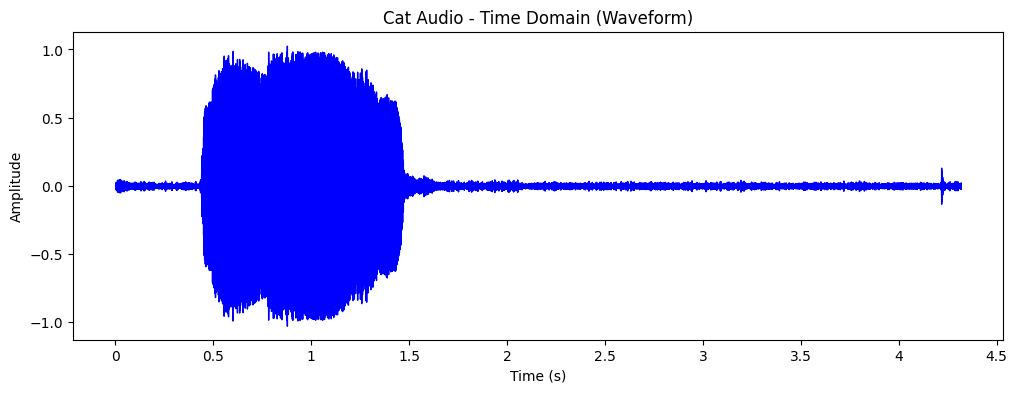

In [25]:
# Plot waveforms
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y_cat, sr=sr_cat, color='blue')
plt.title('Cat Audio - Time Domain (Waveform)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

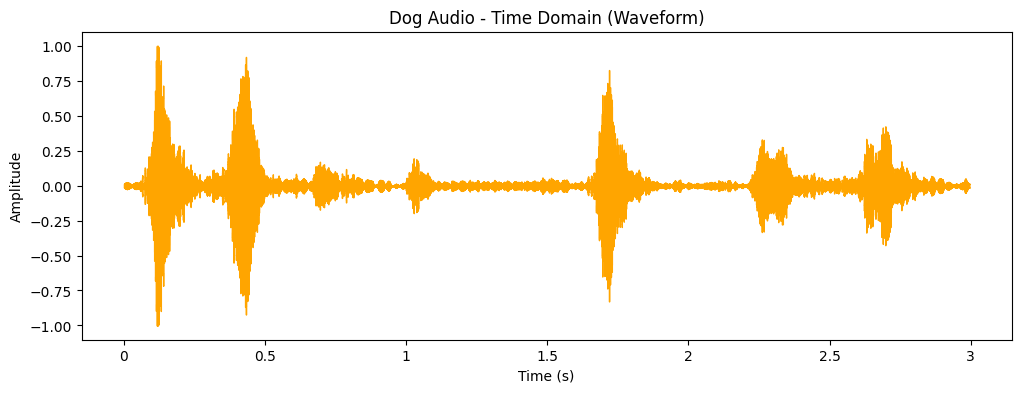

In [30]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y_dog, sr=sr_dog, color='orange')
plt.title('Dog Audio - Time Domain (Waveform)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

### Spectrograms

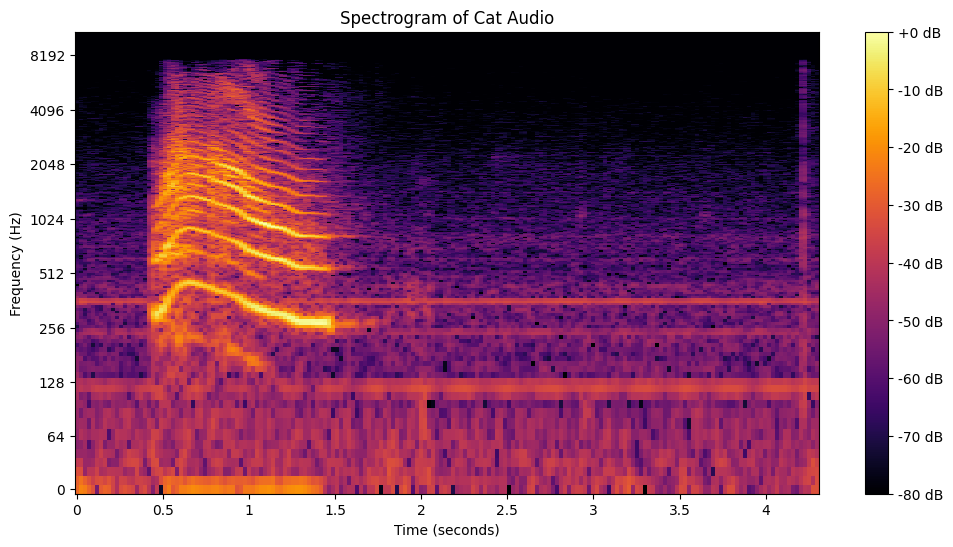

In [35]:
# Compute the Spectrogram
S = librosa.stft(y_cat)  # Compute Short-Time Fourier Transform (STFT)
D = librosa.amplitude_to_db(np.abs(S), ref=np.max)  # Take magnitude (absolute value) before converting to dB

# Plot the Spectrogram
plt.figure(figsize=(12, 6))
librosa.display.specshow(D, x_axis='time', y_axis='log', sr=sr, cmap='inferno')
plt.title("Spectrogram of Cat Audio")
plt.colorbar(format='%+2.0f dB')
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.show()

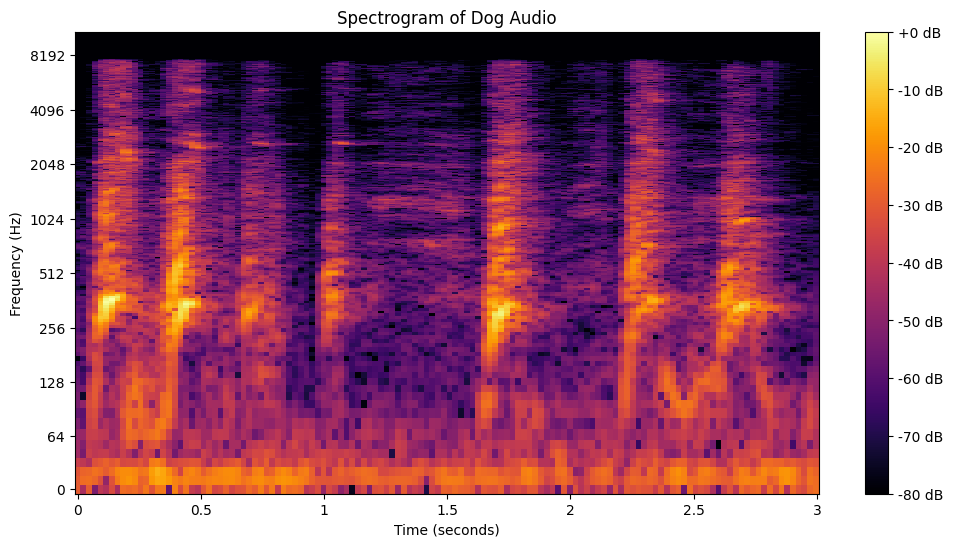

In [36]:
S = librosa.stft(y_dog)  # Compute Short-Time Fourier Transform (STFT)
D = librosa.amplitude_to_db(np.abs(S), ref=np.max)  # Take magnitude (absolute value) before converting to dB

# Plot the Spectrogram
plt.figure(figsize=(12, 6))
librosa.display.specshow(D, x_axis='time', y_axis='log', sr=sr, cmap='inferno')
plt.title("Spectrogram of Dog Audio")
plt.colorbar(format='%+2.0f dB')
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.show()

### Amplitude envelope and RMS

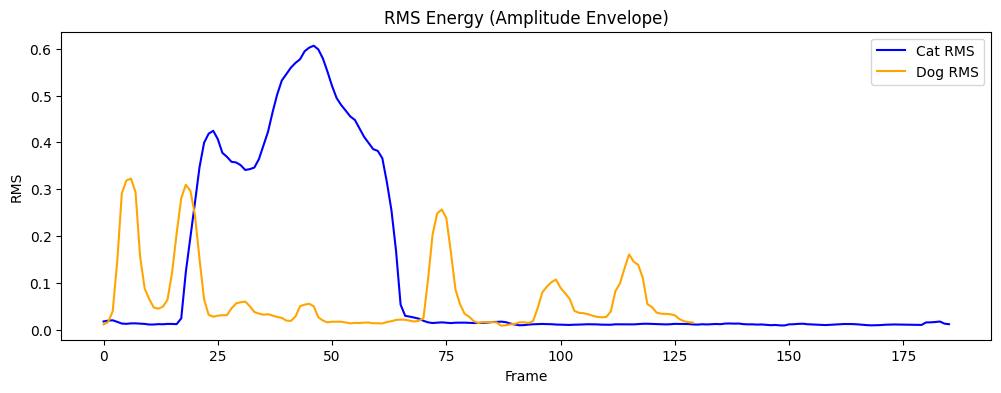

In [37]:
rms_cat = librosa.feature.rms(y=y_cat)[0]
rms_dog = librosa.feature.rms(y=y_dog)[0]
plt.figure(figsize=(12, 4))
plt.plot(rms_cat, label='Cat RMS', color='blue')
plt.plot(rms_dog, label='Dog RMS', color='orange')
plt.title('RMS Energy (Amplitude Envelope)')
plt.xlabel('Frame')
plt.ylabel('RMS')
plt.legend()
plt.show()

### Zero-crossing rate

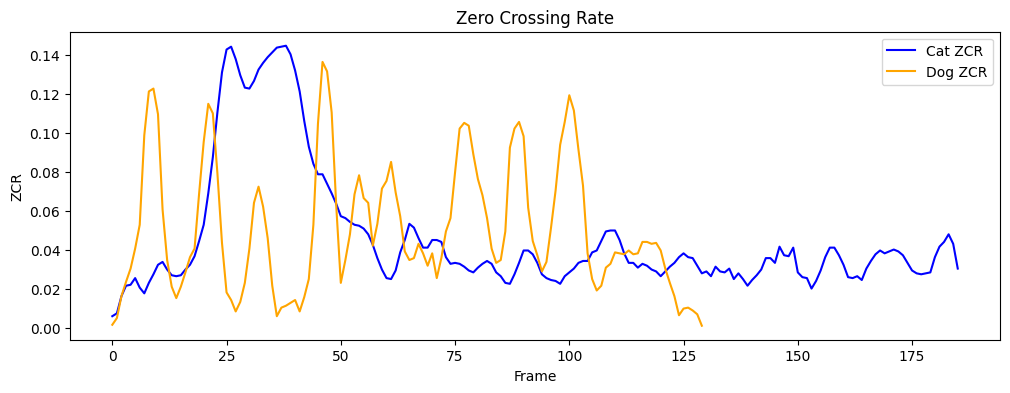

In [38]:
zcr_cat = librosa.feature.zero_crossing_rate(y_cat)[0]
zcr_dog = librosa.feature.zero_crossing_rate(y_dog)[0]
plt.figure(figsize=(12, 4))
plt.plot(zcr_cat, label='Cat ZCR', color='blue')
plt.plot(zcr_dog, label='Dog ZCR', color='orange')
plt.title('Zero Crossing Rate')
plt.xlabel('Frame')
plt.ylabel('ZCR')
plt.legend()
plt.show()

### Feature Extraction

In [40]:
def extract_features_from_directory(directory_path, label):
    features = []
    labels = []

    for file in os.listdir(directory_path):
        if file.endswith('.wav'):
            try:
                file_path = os.path.join(directory_path, file)
                y_audio, sr = librosa.load(file_path, sr=None)
                y_audio = nr.reduce_noise(y=y_audio, sr=sr)
                y_trimmed, _ = librosa.effects.trim(y_audio)
                y_normalized = y_trimmed / max(abs(y_trimmed))
                mfccs = librosa.feature.mfcc(y=y_normalized, sr=sr, n_mfcc=13)
                spectral_centroids = librosa.feature.spectral_centroid(y=y_normalized, sr=sr)
                spectral_rolloff = librosa.feature.spectral_rolloff(y=y_normalized, sr=sr)

                mfccs_mean = np.mean(mfccs, axis=1)
                mfccs_std = np.std(mfccs, axis=1)
                mfccs_min = np.min(mfccs, axis=1)
                mfccs_max = np.max(mfccs, axis=1)
                centroid_mean = np.mean(spectral_centroids)
                centroid_std = np.std(spectral_centroids)
                centroid_min = np.min(spectral_centroids)
                centroid_max = np.max(spectral_centroids)
                rolloff_mean = np.mean(spectral_rolloff)
                rolloff_std = np.std(spectral_rolloff)
                vector = np.hstack([mfccs_mean, mfccs_std, mfccs_min, mfccs_max])
                vector = np.hstack([vector, centroid_mean, centroid_std, centroid_min, centroid_max])
                vector = np.hstack([vector, rolloff_mean, rolloff_std])


                features.append(vector)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {file}: {e}")

    return features, labels

### Training and Test Set

In [9]:
# Train data
train_cat_path = "train/cat"
train_dog_path = "train/dog"
X_cat_train, y_cat_train = extract_features_from_directory(train_cat_path, label=0)
X_dog_train, y_dog_train = extract_features_from_directory(train_dog_path, label=1)

X_train = np.array(X_cat_train + X_dog_train)
y_train = np.array(y_cat_train + y_dog_train)

# Test data
test_cat_path = "test/cats"
test_dog_path = "test/test"
X_cat_test, y_cat_test = extract_features_from_directory(test_cat_path, label=0)
X_dog_test, y_dog_test = extract_features_from_directory(test_dog_path, label=1)

X_test = np.array(X_cat_test + X_dog_test)
y_test = np.array(y_cat_test + y_dog_test)

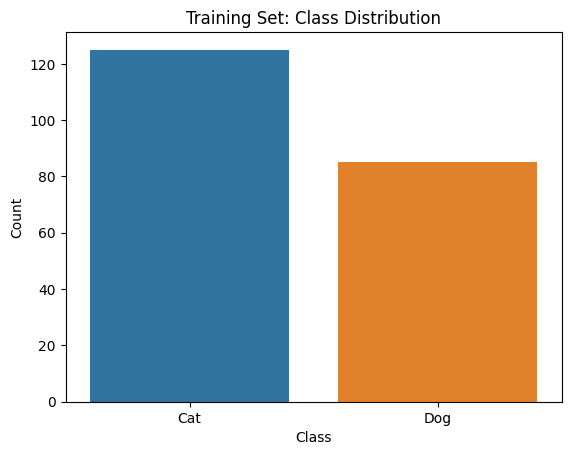

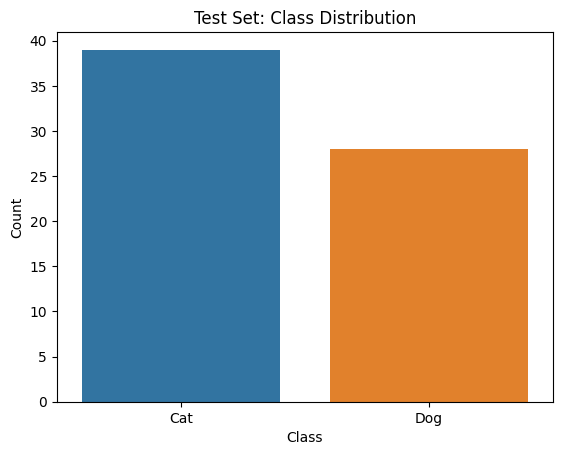

In [12]:
# Combine labels
label_names = {0: 'Cat', 1: 'Dog'}
train_labels_named = [label_names[i] for i in y_train]
test_labels_named = [label_names[i] for i in y_test]

# Definir colores para cada clase
palette = {'Cat': '#1f77b4', 'Dog': '#ff7f0e'}  # azul para gato, naranja para perro

# Plot class distribution
sns.countplot(x=train_labels_named, palette=palette)
plt.title("Training Set: Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

sns.countplot(x=test_labels_named, palette=palette)
plt.title("Test Set: Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

### Correlation and Feature Selection

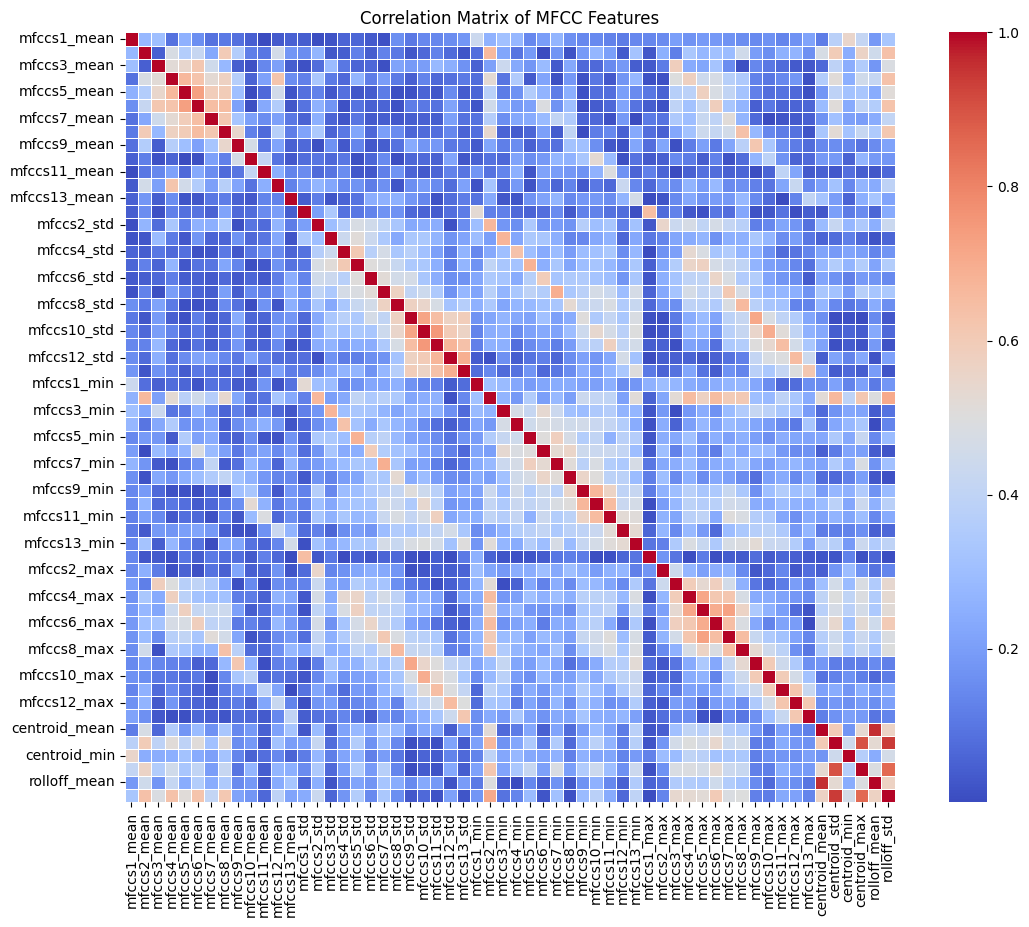

Original feature count: 58
Removed due to high correlation: 3
Remaining features: 55
Selected features: ['mfccs1_mean', 'mfccs2_mean', 'mfccs3_mean', 'mfccs4_mean', 'mfccs5_mean', 'mfccs6_mean', 'mfccs7_mean', 'mfccs8_mean', 'mfccs9_mean', 'mfccs10_mean', 'mfccs11_mean', 'mfccs12_mean', 'mfccs13_mean', 'mfccs1_std', 'mfccs2_std', 'mfccs3_std', 'mfccs4_std', 'mfccs5_std', 'mfccs6_std', 'mfccs7_std', 'mfccs8_std', 'mfccs9_std', 'mfccs10_std', 'mfccs11_std', 'mfccs12_std', 'mfccs13_std', 'mfccs1_min', 'mfccs2_min', 'mfccs3_min', 'mfccs4_min', 'mfccs5_min', 'mfccs6_min', 'mfccs7_min', 'mfccs8_min', 'mfccs9_min', 'mfccs10_min', 'mfccs11_min', 'mfccs12_min', 'mfccs13_min', 'mfccs1_max', 'mfccs2_max', 'mfccs3_max', 'mfccs4_max', 'mfccs5_max', 'mfccs6_max', 'mfccs7_max', 'mfccs8_max', 'mfccs9_max', 'mfccs10_max', 'mfccs11_max', 'mfccs12_max', 'mfccs13_max', 'centroid_mean', 'centroid_std', 'centroid_min']


In [13]:
#Create DataFrame with feature names
feature_names = [f"mfccs{i+1}_{stat}" for stat in ['mean', 'std', 'min', 'max'] for i in range(13)]
feature_names += [f"centroid_{stat}" for stat in ['mean', 'std', 'min', 'max']]
feature_names += [f"rolloff_{stat}" for stat in ['mean', 'std']]
df = pd.DataFrame(X_train, columns=feature_names)

#Compute correlation matrix
corr_matrix = df.corr().abs()

#Visualize (optional)
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Correlation Matrix of MFCC Features")
plt.show()

#Drop highly correlated features (threshold > 0.9)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]

#Reduced feature set
df_reduced = df.drop(columns=to_drop)
X_reduced = df_reduced.values

print(f"Original feature count: {df.shape[1]}")
print(f"Removed due to high correlation: {len(to_drop)}")
print(f"Remaining features: {X_reduced.shape[1]}")
print("Selected features:", df_reduced.columns.tolist())

### Feature Scaling

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Random Forest Classifier

In [15]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [18]:
print("Accuracy:", accuracy_score(y_test, y_pred)*100,'%')
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Cat", "Dog"]))

Accuracy: 91.04477611940298 %

Classification Report:
               precision    recall  f1-score   support

         Cat       0.87      1.00      0.93        39
         Dog       1.00      0.79      0.88        28

    accuracy                           0.91        67
   macro avg       0.93      0.89      0.90        67
weighted avg       0.92      0.91      0.91        67



### Confusion Matrix

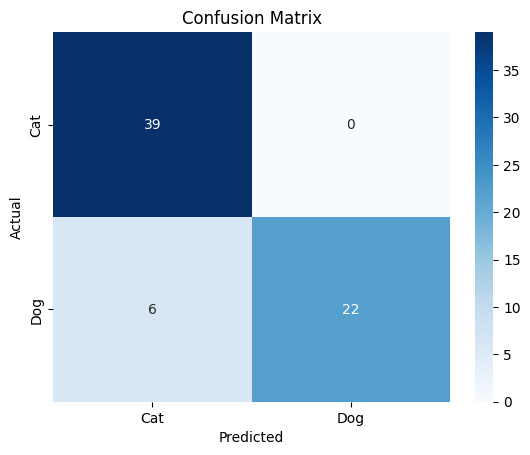

In [21]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Sample Prediction

In [22]:
import random

def random_predict(model, X_test, y_test, scaler):
    # Randomly select an index from the test set
    random_idx = random.randint(0, len(X_test) - 1)

    # Select the sample and its corresponding true label
    sample = X_test[random_idx].reshape(1, -1)
    true_label = y_test[random_idx]

    # Scale the sample using the same scaler as the training data
    sample_scaled = scaler.transform(sample)

    # Predict the label using the trained model
    predicted_label = model.predict(sample_scaled)[0]

    # Map label to corresponding class name
    class_names = ["Cat", "Dog"]

    # Display the prediction and the actual result
    print(f"Sample Index: {random_idx}")
    print(f"Predicted Label: {class_names[predicted_label]}")
    print(f"True Label: {class_names[true_label]}")

    # Optionally, you can also print the raw feature vector
    print(f"Sample Features: {sample[0]}")

# Example of usage:
random_predict(model, X_test, y_test, scaler)


Sample Index: 21
Predicted Label: Cat
True Label: Cat
Sample Features: [-5.37754333e+02  4.55996361e+01 -7.83442640e+00 -1.73514736e+00
  9.97885048e-01  3.52717519e+00  4.94005632e+00  4.54632902e+00
  7.23134816e-01 -1.24766040e+00 -5.88889010e-02 -1.29183280e+00
  3.72753054e-01  1.84191086e+02  7.52763901e+01  4.99250450e+01
  3.26484718e+01  2.04858341e+01  1.91293335e+01  1.21853504e+01
  1.43428869e+01  1.26756010e+01  1.21552591e+01  9.40521336e+00
  1.01225233e+01  8.21155071e+00 -6.58387756e+02 -1.10327835e+02
 -1.59114563e+02 -1.01842331e+02 -6.65792542e+01 -5.64793701e+01
 -5.69838715e+01 -5.79005127e+01 -5.44671326e+01 -5.06089478e+01
 -4.70654221e+01 -4.42895927e+01 -3.16758766e+01 -4.46508331e+01
  2.89967773e+02  8.80319824e+01  5.74109650e+01  4.05093880e+01
  9.30856934e+01  3.81438789e+01  4.62827606e+01  4.22673645e+01
  2.98380928e+01  2.66845016e+01  3.19487114e+01  2.76610527e+01
  8.47914248e+02  1.19599388e+03  3.88250903e+01  6.40974528e+03
  1.30556017e+03  1